In [1]:
from os.path import join
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Поиск углов на фотографии калибровочного шаблона

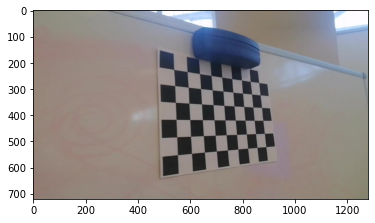

In [4]:
images = glob(join('phone_2', '*.jpeg'))
plt.imshow(plt.imread(images[0]))

In [5]:
# the number of corners on the calibration template
DESC_SHAPE = (6, 9)

objp = np.zeros((DESC_SHAPE[0] * DESC_SHAPE[1], 3), np.float32)
curr = 0
for row in range(DESC_SHAPE[1]):
    for col in range(DESC_SHAPE[0]):
        objp[curr] = np.array([col, row, 0])
        curr += 1

In [6]:
def get_images_points(images):
    '''
    Получение двумерных координат углов клеток в плосткости изображения
    Вход:
    -----
    x: массив с путями до файлов с изображениями
    Выход:
    ------
    imgs_list: массив загруженных в память изображений
    imgpoints_list: массив точек доски в пространстве кадра для каждого изображения
    objpoints_list: массив точек доски в мировом пространстве для каждого изображения
    '''
    imgs_list = [] # загруженные в пямять изображения
    objpoints_list = []  # 3d точки в пространстве калибровочного шаблона
    imgpoints_list = []  # 2d точки в плоскости изображения
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # найдем углы на шахматной доске в первом приближении
        ret, corners = cv2.findChessboardCorners(gray, DESC_SHAPE, None)
        
        # если удалось найти углы, уточним их положение
        if ret == True:
            objpoints_list.append(np.array(objp))
            
            STOP_CRIT = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners_fine = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), STOP_CRIT)
            
            imgpoints_list.append(corners_fine.squeeze())
            imgs_list.append(img)
        else:
            print("No points found")
            
    return imgs_list, objpoints_list, imgpoints_list


In [7]:
imgs_list, objpoints_list, imgpoints_list = get_images_points(images)

No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found
No points found


In [8]:
def draw_corners(image, imgpoints, color=(0, 255, 0), objpoints=None, show=True):
    '''
    Отрисовка двумерных координат точек углов доски
    Вход:
    -----
    image: массив, содержащий изображение (numpy array)
    imgpoints: точки углов на изобржаении
    color: желаемый цвет точек (tuple)
    '''
    image = image.copy()
    for i, point in enumerate(imgpoints):
        col, row = point
        n_rows, n_cols = image.shape[:2]
        if not (0 <= row < n_rows and 0 <= col < n_cols):
            continue
        
        image = cv2.circle(image, (int(col), int(row)), 6, color, -1)
        
        if objpoints is not None:
            objpoint = objpoints[i]
            cv2.putText(image, str(objpoint), (int(col) - 3, int(row) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, 1)
    if show:
        plt.figure(figsize=(22.5, 15))
        plt.imshow(image[:,:,::-1])
        plt.show()
    else:
        return image

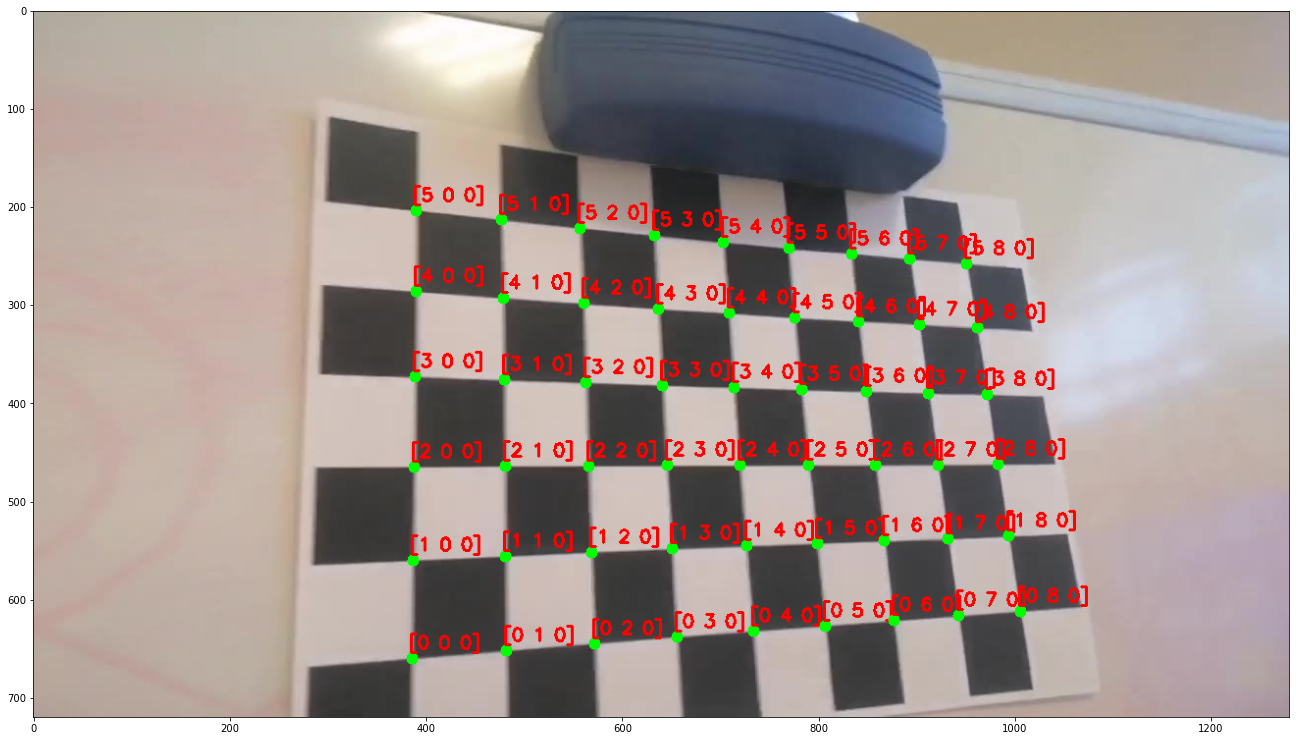

In [9]:
draw_corners(imgs_list[0], imgpoints_list[0], objpoints=objpoints_list[0].astype(int))

In [10]:
shape = plt.imread(images[0]).shape[:2][::-1]
print("Shape:", shape)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_list, imgpoints_list, shape, None, None)

Shape: (1280, 720)


In [11]:
mtx[0] = mtx[0] / shape[0] * 416
mtx[1] = mtx[1] / shape[1] * 234

mtx

array([[316.74517558,   0.        , 209.62414325],
       [  0.        , 317.72686319, 111.75794416],
       [  0.        ,   0.        ,   1.        ]])

Введем несколько вспомогательных функций для проекции 3D точек в координаты изображения и для подсчета ошибки репроекции

In [ ]:
def reprojection_error(imgpoints, imgpoints_new):
    '''
    Подсчет ошибки репроекции
    Вход:
    -----
    imgpoints: точки, заданные априорно
    imgpoints_new: точки, полученные после репроекции
    Выход:
    ------
    err: значение ошибки репроекции
    '''
    
    err = np.sum((imgpoints - imgpoints_new) ** 2)
    return err

Эта функция для проекции 3D точек с помощью найденной матрицы проекции P на плоскость изображения.

In [ ]:
def projection_points(objpoints, P):
    '''
    Вычисление координат точек на изображении
    Вход:
    -----
    objpoints: координаты точек в мировой системе
    P: матрица параметров камеры
    Выход:
    ------
    imgpoints_new: координаты точек в пространстве кадра
    '''
    n = objpoints.shape[0]
    objpoints_g = np.concatenate((objpoints.T, np.ones((1, n))))
    imgpoints_new = (P @ objpoints_g).T
    imgpoints_new = imgpoints_new / imgpoints_new[:, -1][:, np.newaxis]
    imgpoints_new = imgpoints_new[:, :2]
    
    return imgpoints_new

In [ ]:
for objpoints, imgpoints, image, rvec, tvec, in zip(objpoints_list,
                                                    imgpoints_list,
                                                    imgs_list,
                                                    rvecs,
                                                    tvecs):
    if imgpoints is None:
        continue
    
    Rt = np.zeros((3, 4))
    Rt[:, :3] = cv2.Rodrigues(rvec)[0]
    Rt[:, -1:] = tvec

    P_denormalized = mtx @ Rt
    imgpoints_new = projection_points(objpoints, P_denormalized)
    
    drw_img = draw_corners(image, imgpoints, show=False)
    draw_corners(drw_img, imgpoints_new, color=(0, 0, 255))
    
    rep_err = reprojection_error(imgpoints, imgpoints_new)
    print("Reprojection error:", rep_err)